# Assignment 2

2.	For the companies we used in Q1, use monthly data from 2016-2021 to implement the following models:

###  a.	One factor mode (use S&P 500 to represent the market)

In [1]:
%reset -f
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf

class OneFactorCAPM():
    
    def __init__(self, company, start_date='2016-1-1', end_date='2021-12-31'):
        self.risky_asset=company
        self.market_index = '^GSPC'
        self.risk_free='^IRX'
        self.start_date = start_date
        self.end_date = end_date
    
    def prepare_data(self):
        df = yf.download([self.risky_asset, self.market_index, self.risk_free],
                         start=self.start_date,
                         end=self.end_date,
                         adjusted=True,
                         progress=False)['Adj Close']
        self.X = df.rename(columns={
            self.risky_asset:'asset', 
            self.market_index: 'market', 
            self.risk_free:'rf'}
                     ).resample('M').last()
        self.X['asset']=self.X.asset.pct_change()
        self.X['market']=self.X.market.pct_change()
        self.X.dropna(inplace=True)
        self.X['rf']=(1+self.X['rf']/100/4)**(1/4)-1
        self.calculate_beta()
        self.X['asset_ex']=self.X['asset']-self.X['rf']
        self.X['market_ex']=self.X['market']-self.X['rf']
        # separate target
        self.y = self.X['asset_ex']
        self.X= self.X['market_ex']
        # add constant
        self.X = sm.add_constant(self.X)
        return self.X
        
        
    def calculate_beta(self):
        covariance = self.X.cov().iloc[0,1]
        market_variance = self.X.market.var()
        self.beta = covariance / market_variance
    
    
    def create_model(self):
        # define and fit the regression model 
        capm_model = sm.OLS(self.y, self.X).fit()
        print('\n'+f'OneFactorModel: {self.risky_asset}'.center(80, '='))
        print(capm_model.summary())
        return capm_model
    
    def estimate_capm(self):
        self.prepare_data()
        model = self.create_model()
        return model

In [2]:
stocks = ['AAPL','AMZN','GOOGL','FB', 'MCD', 'GM', 'TSLA','PFE']
stock_model = {}
for s in stocks:
    capm = OneFactorCAPM(s)
    one_factor_model = capm.estimate_capm()
    stock_model[s] = one_factor_model


==============================OneFactorModel: AAPL==============================
                            OLS Regression Results                            
Dep. Variable:               asset_ex   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     42.16
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.09e-08
Time:                        23:22:08   Log-Likelihood:                 93.303
No. Observations:                  71   AIC:                            -182.6
Df Residuals:                      69   BIC:                            -178.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------


===============================OneFactorModel: GM===============================
                            OLS Regression Results                            
Dep. Variable:               asset_ex   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     28.68
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.06e-06
Time:                        23:22:10   Log-Likelihood:                 81.951
No. Observations:                  71   AIC:                            -159.9
Df Residuals:                      69   BIC:                            -155.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### b.	Fama-French 3 and 5 factor models.

### 3 factor models

In [3]:
class FamaFrench3FactorModel():
    def __init__(self, risk_asset, start_date,end_date):
        self.market_index = '^GSPC'
        self.start_date = start_date
        self.end_date = end_date
        self.weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
        self.risk_asset = risk_asset
        
    def download_risk_asset_data(self):
        asset_df = yf.download(self.risk_asset,
                       start=self.start_date,
                       end=self.end_date,
                       adjusted=True,
                       progress=False)

        print(f'Downloaded {asset_df.shape[0]} rows of data.')
        asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
        # reformat index for joining
        asset_df.index = asset_df.index.strftime('%Y-%m')

        #Calculate the portfolio returns:
        print(self.risk_asset)
        asset_df['portfolio_returns'] = np.matmul(asset_df[self.risk_asset].values,self.weights)
        asset_df.head()
        return asset_df
        
    def load_factor_data(self):
        df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=self.start_date)[0]
        df_three_factor = df_three_factor.div(100)
        df_three_factor.index = df_three_factor.index.format()
        return df_three_factor
    
    def prepare_dataset(self):
        asset_df = self.download_risk_asset_data()
        df_three_factor = self.load_factor_data()
        ff_data = asset_df.join(df_three_factor).drop(self.risk_asset, axis=1)
        ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
        ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf
        ff_data.head()
        return ff_data
    
    def rolling_factor_model(self, input_data, formula, window_size):
        coeffs = []

        for start_index in range(len(input_data) - window_size + 1):        
            end_index = start_index + window_size

            # define and fit the regression model 
            ff_model = smf.ols(
                formula=formula, 
                data=input_data[start_index:end_index]
            ).fit()

            # store coefficients
            coeffs.append(ff_model.params)

        coeffs_df = pd.DataFrame(
            coeffs, 
            index=input_data.index[window_size - 1:]
        )
        print(ff_model.summary())
        return coeffs_df, ff_model
    
    def estimate_three_factor(self):
        MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
        ff_data = self.prepare_dataset()
        results_df, ff_model = self.rolling_factor_model(ff_data, 
                                          MODEL_FORMULA, 
                                          window_size=60)
        results_df.plot(title = 'Rolling Fama-French Three-Factor model')
        return ff_model

Downloaded 1510 rows of data.
['AAPL', 'AMZN', 'GOOGL', 'FB', 'MCD', 'GM', 'TSLA', 'PFE']
                            OLS Regression Results                            
Dep. Variable:           portf_ex_rtn   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     49.84
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           8.03e-16
Time:                        23:22:13   Log-Likelihood:                 80.986
No. Observations:                  60   AIC:                            -154.0
Df Residuals:                      56   BIC:                            -145.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

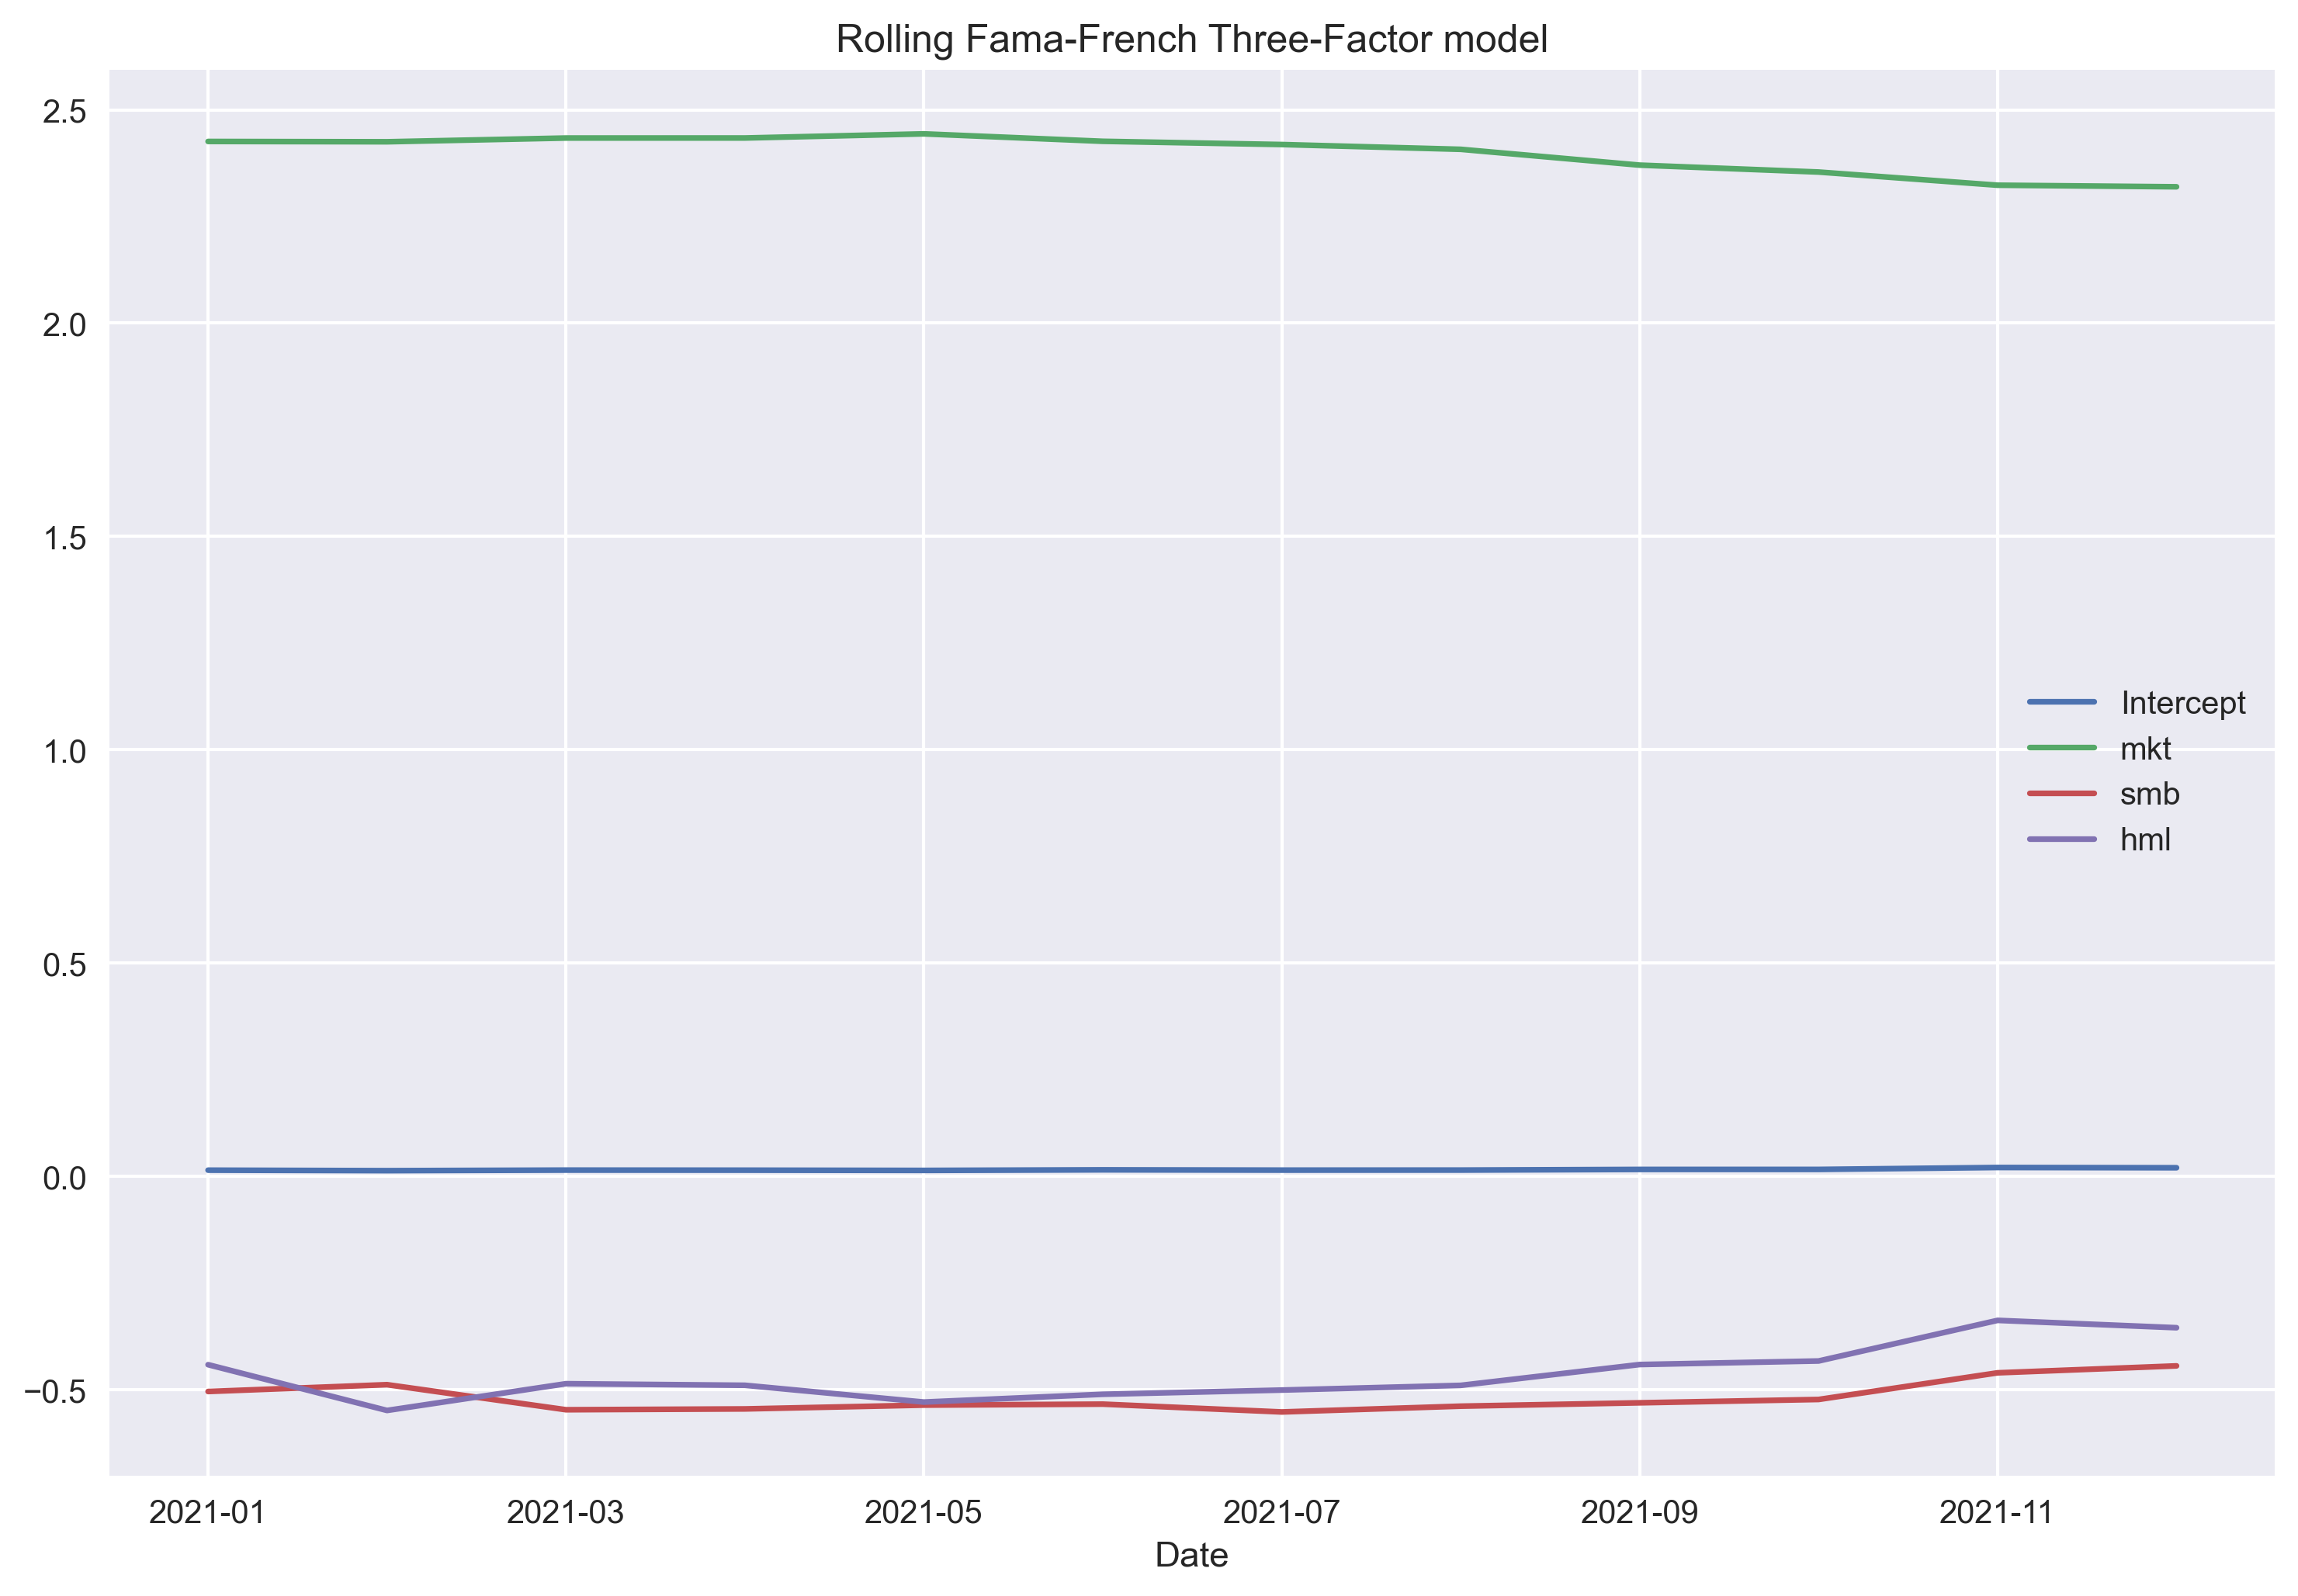

In [4]:
three_factor = FamaFrench3FactorModel(stocks, start_date='2016-1-1', end_date='2021-12-31')
three_factor_model = three_factor.estimate_three_factor()

### 5 factor models

In [5]:
class FamaFrench5FactorModel():
    def __init__(self, risk_asset, start_date='2016-1-1',end_date='2021-12-31'):
        self.market_index = '^GSPC'
        self.start_date = start_date
        self.end_date = end_date
        self.weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
        self.risk_asset = risk_asset
        
    def download_risk_asset_data(self):
        asset_df = yf.download(self.risk_asset,
                       start=self.start_date,
                       end=self.end_date,
                       adjusted=True,
                       progress=False)

        print(f'Downloaded {asset_df.shape[0]} rows of data.')
        y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

        y.index = y.index.strftime('%Y-%m')
        y.name = 'return'
        return y
        
    def load_factor_data(self):
        df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=self.start_date)[0]
        df_five_factor.index = df_five_factor.index.format()
        return df_five_factor
    
    
    def prepare_dataset(self):
        y = self.download_risk_asset_data()
        df_five_factor = self.load_factor_data()
        five_factor_data = df_five_factor.join(y)
        five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']
        five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100
        five_factor_data.index = [pd.to_datetime(x, format='%Y-%m') for x in five_factor_data.index]
        five_factor_data = five_factor_data.loc[self.start_date:self.end_date]
        five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf
        five_factor_data.head()
        return five_factor_data
    
    
    def estimate_five_factor(self):
        five_factor_data = self.prepare_dataset()
        five_factor_model = smf.ols(
            formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
            data=five_factor_data
        ).fit()
        print('\n'+f'FiveFactorModel: {self.risk_asset}'.center(80, '='))
        print(five_factor_model.summary())
        return five_factor_model

In [6]:
for s in stocks:
    five_factor = FamaFrench5FactorModel(s)
    five_factor_model = five_factor.estimate_five_factor()

Downloaded 1510 rows of data.

=============================FiveFactorModel: AAPL==============================
                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     14.57
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.45e-09
Time:                        23:22:14   Log-Likelihood:                 103.03
No. Observations:                  71   AIC:                            -194.1
Df Residuals:                      65   BIC:                            -180.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

Downloaded 1510 rows of data.

==============================FiveFactorModel: MCD==============================
                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     9.033
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           1.48e-06
Time:                        23:22:16   Log-Likelihood:                 134.08
No. Observations:                  71   AIC:                            -256.2
Df Residuals:                      65   BIC:                            -242.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

### c.	Use the resulting models to calculate the predicted monthly returns for each month in 2021.   You can use the actual factor values in 2021 (S&P 500 index, and the F-F factor values).

In [7]:
pred_start_date = '2020-12-31'
pred_end_date = '2021-12-31'

In [8]:
i=0
data = []
for k, v in stock_model.items():
    _one_factor = OneFactorCAPM(k, start_date=pred_start_date, end_date=pred_end_date)
    _one_factor_data = _one_factor.prepare_data()
    r = v.predict(_one_factor_data)
    if i==0:
        one_factor_pred = pd.DataFrame(r, columns=[f'predicted_{k}']).reset_index()
        i += 1
    else:
        result = pd.DataFrame(r).rename(columns={0:f'predicted_{k}'}).reset_index()
        one_factor_pred=one_factor_pred.merge(result,how='left',left_on='Date',right_on='Date')
    


In [9]:
_three_factor = FamaFrench3FactorModel(stocks, start_date=pred_start_date, end_date=pred_end_date)
_three_factor_data = _three_factor.prepare_dataset()
tfactor_pred_result = three_factor_model.predict(_three_factor_data)
print(tfactor_pred_result)

Downloaded 252 rows of data.
['AAPL', 'AMZN', 'GOOGL', 'FB', 'MCD', 'GM', 'TSLA', 'PFE']
Date
2021-01   -0.022576
2021-02    0.050631
2021-03    0.076433
2021-04    0.152181
2021-05    0.003289
2021-06    0.104129
2021-07    0.073665
2021-08    0.090280
2021-09   -0.102542
2021-10    0.186354
2021-11   -0.007660
2021-12    0.087846
dtype: float64


In [10]:
_five_factor = FamaFrench5FactorModel('AAPL', start_date=pred_start_date,end_date=pred_end_date)
five_factor_data = _five_factor.prepare_dataset()
ffactor_pred_result = five_factor_model.predict(five_factor_data)
print(ffactor_pred_result)

Downloaded 252 rows of data.
2021-01-01    0.003629
2021-02-01   -0.031441
2021-03-01    0.089442
2021-04-01    0.033952
2021-05-01    0.030220
2021-06-01    0.020882
2021-07-01    0.059864
2021-08-01    0.003659
2021-09-01   -0.042547
2021-10-01    0.054842
2021-11-01    0.067581
2021-12-01    0.101373
dtype: float64


### d.	Compare them with the actual average monthly returns for the stocks.

In [11]:
# ASSETS = ['AAPL','AMZN','GOOGL','FB', 'MCD', 'GM', 'TSLA','PFE']
WEIGHTS = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

asset_df = yf.download(stocks,
                       start=pred_start_date,
                       end=pred_end_date,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')
#Calculate the monthly returns on the risky assets:
asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

#Calculate the portfolio returns:
asset_df['portfolio_returns'] = np.matmul(asset_df[stocks].values,WEIGHTS)
asset_df = asset_df.reset_index()
asset_df['Date'] = pd.to_datetime(asset_df['Date'])

Downloaded 252 rows of data.


In [12]:
t_pred_result = pd.DataFrame(tfactor_pred_result)
t_pred_result.index.name = 'Date'
t_pred_result = t_pred_result.reset_index()
t_pred_result = t_pred_result.rename(columns={0: "3factor_predict_returns"})
t_pred_result['Date'] = pd.to_datetime(t_pred_result['Date'])

In [13]:
f_pred_result = pd.DataFrame(ffactor_pred_result)
f_pred_result.index.name = 'Date'
f_pred_result = f_pred_result.reset_index()
f_pred_result = f_pred_result.rename(columns={0: "3factor_predict_returns"})

In [14]:
prediction_result = asset_df.merge(f_pred_result,how='left',left_on='Date',right_on='Date')
prediction_result = asset_df.merge(t_pred_result,how='left',left_on='Date',right_on='Date')
one_factor_pred['Date'] = one_factor_pred['Date'].apply(lambda dt: dt.replace(day=1))
prediction_result = prediction_result.merge(one_factor_pred,how='left',left_on='Date',right_on='Date')
prediction_result

,Date,AAPL,AMZN,FB,GM,GOOGL,MCD,PFE,TSLA,portfolio_returns,3factor_predict_returns,predicted_AAPL,predicted_AMZN,predicted_GOOGL,predicted_FB,predicted_MCD,predicted_GM,predicted_TSLA,predicted_PFE
0,2021-01-01,-0.005501,-0.015576,-0.054291,0.217099,0.042633,-0.031410,-0.014112,0.124506,0.065837,-0.022576,0.002827,0.000948,-0.005469,-0.012146,-0.001469,-0.012971,0.012932,-0.002071
1,2021-02-01,-0.079712,-0.035328,-0.002748,0.012826,0.106465,-0.002077,-0.067131,-0.148740,-0.054112,0.050631,0.048312,0.041317,0.034461,0.034622,0.021716,0.031048,0.087976,0.023891
2,2021-03-01,0.007340,0.000372,0.143273,0.119423,0.020085,0.087319,0.081815,-0.011207,0.112105,0.076433,0.068298,0.059054,0.052006,0.055170,0.031903,0.050389,0.120949,0.035299
3,2021-04-01,0.076218,0.120663,0.103725,-0.004177,0.141080,0.053270,0.066796,0.062147,0.154930,0.152181,0.080504,0.069888,0.062722,0.067721,0.038125,0.062202,0.141088,0.042266
4,2021-05-01,-0.050497,-0.070470,0.011228,0.036526,0.001423,-0.003805,0.011944,-0.118713,-0.045591,0.003289,0.023163,0.018997,0.012383,0.008764,0.008897,0.006709,0.046484,0.009537
5,2021-06-01,0.099109,0.067355,0.057737,-0.002361,0.036040,-0.012399,0.011103,0.087137,0.085930,0.104129,0.043572,0.037110,0.030300,0.029748,0.019300,0.026460,0.080155,0.021186
6,2021-07-01,0.064982,-0.032722,0.024704,-0.039378,0.103506,0.050738,0.103109,0.011034,0.071493,0.073665,0.044224,0.037689,0.030872,0.030418,0.019632,0.027092,0.081232,0.021558
7,2021-08-01,0.042489,0.043034,0.064777,-0.137755,0.074009,-0.016267,0.076150,0.070605,0.054261,0.090280,0.051850,0.044456,0.037567,0.038259,0.023519,0.034471,0.093812,0.025910
8,2021-09-01,-0.068037,-0.053518,-0.105409,0.075495,-0.076169,0.015371,-0.066421,0.054042,-0.056161,-0.102542,-0.041661,-0.038535,-0.044525,-0.057888,-0.024145,-0.056025,-0.060468,-0.027465
9,2021-10-01,0.058657,0.026602,-0.046613,0.032631,0.107499,0.018415,0.016973,0.436530,0.162674,0.186354,0.100892,0.087982,0.080620,0.088684,0.048517,0.081933,0.174725,0.053903
